# Optimally Creating and Assigning Work Orders Based on Routes

Suppose our organization needs to perform restaurant/brewery inspections in the Greater Portland, Maine area. Let's assume that there are around 25 breweries that need to be inspected and that there are 5 workers that are available to do the inspections. As the supervisor of these workers I'm going to develop a Python Script (well, Jupyter Notebook in this case) that will optimally create distinct routes for my workers, create assignments at the brewery locations, and then assign the assignment to the correct worker.

### Import ArcGIS API for Python
Let's import some libraries and connect to our organization

In [1]:
import pandas as pd
import arcgis
from arcgis.gis import GIS
from arcgis.apps import workforce
pd.options.display.max_columns = None

gis = GIS("https://arcgis.com", "workforce_scripts")
project = workforce.Project(gis.content.search("type:'Workforce Project' Maine Brewery Inspections")[0])
project.assignments_item.layers[0].delete_features(where="1=1")

Enter password: ········


### View the breweries that need to be inspected


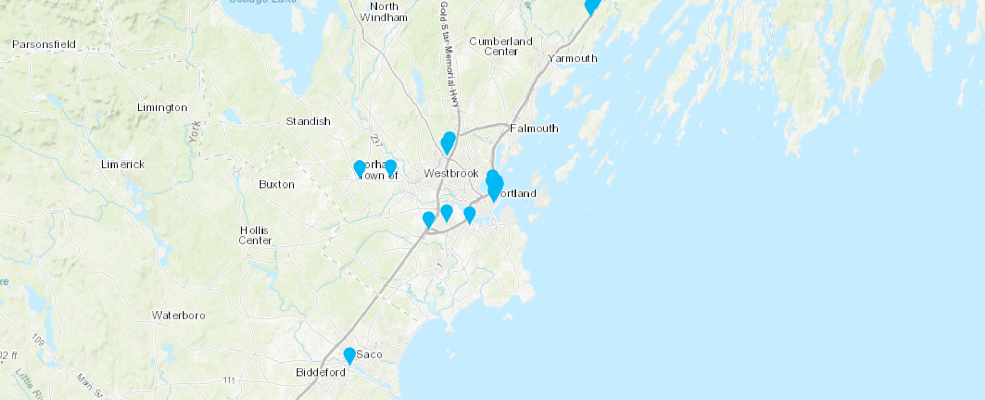

In [2]:
breweries = gis.content.search("type:'Feature Service' owner:workforce_scripts Maine Breweries")[0].layers[0]
breweries.filter = "location in ('Portland','South Portland','Gorham','Biddeford','Scarborough', 'Topsham','Freeport')"
webmap = gis.map("Portland, ME", zoomlevel=10)
webmap.add_layer(breweries)
webmap

In [3]:
breweries_df = breweries.query(where=breweries.filter, out_fields="objectid,name,location,url", as_df=True)
breweries_df

,SHAPE,location,name,objectid,url
0,"{""x"": -7842761.363299999, ""y"": 5387249.8882, ""...",Biddeford,Banded Horn Brewing Company,1,http://www.bandedhorn.com/
1,"{""x"": -7827788.769099999, ""y"": 5419613.4034999...",Portland,Allagash Brewing Company,2,http://www.allagash.com
2,"{""x"": -7827976.476500001, ""y"": 5419540.3176999...",Portland,Austin Street Brewery,9,http://www.austinstreetbrewery.com/
3,"{""x"": -7827992.3013, ""y"": 5419591.972199999, ""...",Portland,Bissell Brothers,10,http://www.bissellbrothers.com/
4,"{""x"": -7820870.4265, ""y"": 5414061.9846, ""spati...",Portland,Bunker Brewing Co.,11,http://bunkerbrewingco.com/
5,"{""x"": -7824456.296700001, ""y"": 5408829.7722999...",Portland,Fore River Brewing Company,12,http://www.foreriverbrewing.com/
6,"{""x"": -7827960.353, ""y"": 5419581.223200001, ""s...",Portland,Foundation Brewing Company,13,http://foundationbrew.com/
7,"{""x"": -7827381.4022, ""y"": 5420339.920400001, ""...",Portland,Geary Brewing Co.,14,http://www.gearybrewing.com/
8,"{""x"": -7820579.2434, ""y"": 5412405.279299997, ""...",Portland,Gritty's,15,http://grittys.com/
9,"{""x"": -7820871.3807, ""y"": 5414439.781300001, ""...",Portland,Gruit,16,http://fermentory.com/


### Create a route for each worker

Now that we know what we're working with, let's use the Plan Routes tool to generate the most optimal routes for each of the workers. First we need to define where the workers will start their routes. Each worker will begin from the main office located at 100 Commercial Street, Portland Maine. We'll use the geocoding module to get an exact location for this address.

In [4]:
from arcgis.geocoding import geocode
start_location = geocode("100 Commercial Street, Portland, ME", out_sr={"wkid": 102100})[0]["location"]
start_location["spatialReference"] = {"wkid": 102100}
start_location

{'x': -7820327.030292237,
 'y': 5412458.446412361,
 'spatialReference': {'wkid': 102100}}

Next we need to create a feature at this location

In [5]:
feature = arcgis.features.Feature(
    attributes={
        "ObjectID": 1,
        "Name": "Office"
    },
    geometry=start_location
)

Next, we'll create a Feature Set from the feature. Then we'll create a Feature Collection from the Feature Set. Finally, we'll format the layer so that it conforms to the expected input format defined [here](https://doc.arcgis.com/en/arcgis-online/analyze/plan-routes.htm).

In [6]:
feature_set = arcgis.features.FeatureSet([feature])
feature_collection = arcgis.features.FeatureCollection.from_featureset(feature_set)
start_layer = {"layerDefinition": feature_collection.properties["layers"][0]["layerDefinition"], "featureSet": feature_set.value}

Then we'll run the Plan Routes tool using the breweries layer as list of stops to route to. We'll set the number of routes equal to the number of workers. We'll also set the start time and start location as well as few other parameters.

In [7]:
from datetime import datetime
workers = project.workers.search()
results = arcgis.features.analysis.plan_routes(breweries,       # Feature Layer of Stops
                                    len(workers),               # Number of routes to generate
                                    5,                          # Maximum stops per route
                                    datetime.now(),             # Start time of route
                                    start_layer,                # The dictionary we created to represent the start location
                                    stop_service_time=60,       # How much time in minutes to spend at each stop
                                    max_route_time=480,         # The maximum time for the worker to complete the route
                                    )
results

{'routes_layer': <FeatureCollection>,
 'assigned_stops_layer': <FeatureCollection>,
 'unassigned_stops_layer': <FeatureCollection>}

Let's see what the routes look like


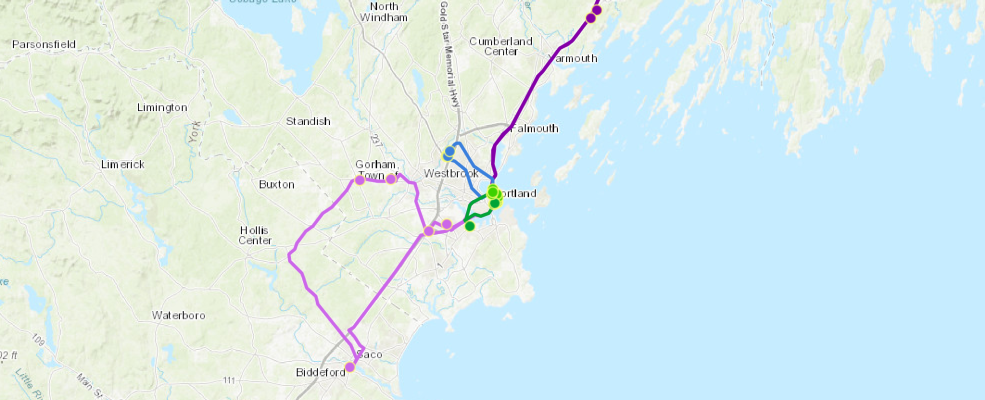

In [8]:
webmap = gis.map("Portland, ME", zoomlevel=10)
webmap.add_layer(results["routes_layer"])
webmap.add_layer(results["assigned_stops_layer"])
webmap

Let's look at what data is in route

In [9]:
routes = results['routes_layer'].query().sdf
routes

,EndTime,EndTimeUTC,ObjectID,RouteLayerItemID,RouteLayerItemURL,RouteName,SHAPE,StartTime,StartTimeUTC,StopCount,TotalStopServiceTime,TotalTime,TotalTravelTime,Total_Kilometers,Total_Miles
0,2019-06-27 22:16:16.288000107,2019-06-28 02:16:16.288000107,1,None,None,Office - Route1,"{""paths"": [[[-7820328.7299246695, 5412461.7125...",2019-06-27 18:05:30,2019-06-27 22:05:30,3,180,250.771469,70.771469,90.096670,55.983614
1,2019-06-28 00:38:56.954999924,2019-06-28 04:38:56.954999924,2,None,None,Office - Route2,"{""paths"": [[[-7820328.7299246695, 5412461.7125...",2019-06-27 18:05:30,2019-06-27 22:05:30,5,300,393.449247,93.449247,81.675689,50.751046
2,2019-06-27 23:42:35.563999891,2019-06-28 03:42:35.563999891,3,None,None,Office - Route3,"{""paths"": [[[-7820328.7299246695, 5412461.7125...",2019-06-27 18:05:30,2019-06-27 22:05:30,5,300,337.092741,37.092741,20.883495,12.976434
3,2019-06-27 23:19:28.506000042,2019-06-28 03:19:28.506000042,4,None,None,Office - Route4,"{""paths"": [[[-7820328.7299246695, 5412461.7125...",2019-06-27 18:05:30,2019-06-27 22:05:30,5,300,313.975093,13.975093,4.072390,2.530472
4,2019-06-27 22:24:41.026999950,2019-06-28 02:24:41.026999950,5,None,None,Office - Route5,"{""paths"": [[[-7820328.7299246695, 5412461.7125...",2019-06-27 18:05:30,2019-06-27 22:05:30,4,240,259.183780,19.183780,12.238102,7.604423


You can see that each route has a name, total time, and total distance among other things. Let's see what information is provided in an assigned stop.

In [10]:
stops = results['assigned_stops_layer'].query().sdf
stops

,ArriveTime,ArriveTimeUTC,CreationDate,Creator,DepartTime,DepartTimeUTC,EditDate,Editor,FromPrevDistance,FromPrevDistanceKilometers,FromPrevTravelTime,GlobalID_2,OBJECTID,OID,RouteName,SHAPE,Sequence,ServiceTime,StopType,address,contactnum,dining,district,globalid,location,name,snacks,tastingroo,tour,uniqueid,url
0,2019-06-27 18:05:30.000000000,2019-06-27 22:05:30.000000000,NaT,None,2019-06-27 18:05:30.000000000,2019-06-27 22:05:30.000000000,NaT,None,0.000000,0.000000,0.000000,None,1,1,Office - Route1,"{""x"": -7820327.030324951, ""y"": 5412458.4464164...",1,0,Route start,None,None,NaN,NaN,None,None,None,NaN,NaN,NaN,None,None
1,2019-06-27 18:25:40.118999958,2019-06-27 22:25:40.118999958,2018-12-03 14:43:15,nitroadmin,2019-06-27 19:25:40.118999958,2019-06-27 23:25:40.118999958,2018-12-03 14:43:15,nitroadmin,16.001207,25.751383,20.168643,{8382834F-E2B0-4023-8573-67A475DDB036},2,2,Office - Route1,"{""x"": -7805915.979097417, ""y"": 5440666.2457726...",2,60,Stop,None,207-221-5711,0.0,2.0,c8991bf0-aeba-449f-90ce-cef7e5c87fdf,Freeport,Maine Beer Company,1.0,1.0,0.0,86a5a077-a0ce-41c7-9ab4-5d023f2142fd,http://www.mainebeercompany.com/
2,2019-06-27 19:27:12.401999950,2019-06-27 23:27:12.401999950,2018-12-03 14:43:15,nitroadmin,2019-06-27 20:27:12.401999950,2019-06-28 00:27:12.401999950,2018-12-03 14:43:15,nitroadmin,0.691558,1.112951,1.538058,{A129CFC9-26CB-4A00-B3FB-60945898DD01},3,3,Office - Route1,"{""x"": -7804916.088462027, ""y"": 5441788.6862878...",3,60,Stop,None,207-865-4321,1.0,2.0,0775244f-d32c-434c-91cd-40abf1b2c77d,Freeport,Gritty's,1.0,1.0,1.0,da76f11c-e366-4634-9e42-04466f0573f4,http://grittys.com
3,2019-06-27 20:43:12.250999927,2019-06-28 00:43:12.250999927,2018-12-03 14:43:15,nitroadmin,2019-06-27 21:43:12.250999927,2019-06-28 01:43:12.250999927,2018-12-03 14:43:15,nitroadmin,12.613529,20.299456,15.997474,{B292916D-256B-49DF-B5A2-1602881C6D0F},4,4,Office - Route1,"{""x"": -7788449.072572963, ""y"": 5453299.6818928...",4,60,Stop,None,207-725-0162,1.0,5.0,e8af7140-8335-4132-a97d-c1d8d5fdf97b,Topsham,Sea Dog Brewing Company,0.0,0.0,0.0,b1ed0cc8-3a60-4c2d-8285-7d8d768ff3d8,http://www.seadogbrewing.com/topsham.php
4,2019-06-27 22:16:16.288000107,2019-06-28 02:16:16.288000107,NaT,None,2019-06-27 22:16:16.288000107,2019-06-28 02:16:16.288000107,NaT,None,26.677321,42.932879,33.067294,None,5,5,Office - Route1,"{""x"": -7820327.030324951, ""y"": 5412458.4464164...",5,0,Route end,None,None,NaN,NaN,None,None,None,NaN,NaN,NaN,None,None
5,2019-06-27 18:05:30.000000000,2019-06-27 22:05:30.000000000,NaT,None,2019-06-27 18:05:30.000000000,2019-06-27 22:05:30.000000000,NaT,None,0.000000,0.000000,0.000000,None,6,6,Office - Route2,"{""x"": -7820327.030324951, ""y"": 5412458.4464164...",1,0,Route start,None,None,NaN,NaN,None,None,None,NaN,NaN,NaN,None,None
6,2019-06-27 18:33:13.648999929,2019-06-27 22:33:13.648999929,2018-12-03 14:43:15,nitroadmin,2019-06-27 19:33:13.648999929,2019-06-27 23:33:13.648999929,2018-12-03 14:43:15,nitroadmin,17.733960,28.539972,27.727486,{C9EB2901-FAF6-4A88-B91C-0EA23B056FD4},7,7,Office - Route2,"{""x"": -7842761.363331625, ""y"": 5387249.8881664...",2,60,Stop,None,207-776-1242,0.0,1.0,12704709-a9e9-4f74-a9f4-137b6fd8b7a4,Biddeford,Banded Horn Brewing Company,0.0,1.0,1.0,11aa001e-dfdf-40e0-8846-7341e93d9135,http://www.bandedhorn.com/
7,2019-06-27 20:02:49.292000055,2019-06-28 00:02:49.292000055,2018-12-03 14:43:15,nitroadmin,2019-06-27 21:02:49.292000055,2019-06-28 01:02:49.292000055,2018-12-03 14:43:15,nitroadmin,17.076789,27.482360,29.594052,{774E4DCA-AF08-44D5-A225-2AA0F26DC46A},8,8,Office - Route2,"{""x"": -7841267.914577488, ""y"": 5415839.1297598...",3,60,Stop,None,207-839-2337,1.0,2.0,8eafa455-64bb-4dc8-a216-fe3d3d64e975,Gorham,Sebago Brewing Co.,0.0,0.0,0.0,22ba04da-e6a0-41c9-b567-8b0dabde618a,http://sebagobrewing.com/
8,2019-06-27 21:10:22.230999947,2019-06-28 01:10:22.230999947,2018-12-03 14:43:15,nitroadmin,2019-06-27 22:10:22.230999947,2019-06-28 02:10:22.230999947,2018-12-03 14:43:15,nitroadmin,3.6

You can see each row in the above table contains the attributes of each Brewery along with information about which route it is on. You'll also notice that there are several additional stops not related to a brewery. These are the starting and ending locations of each route.

### Create Assignment and Assign To Worker

For each route that was generated we will select a random worker to complete that route. Then we'll find the breweries that were assigned to that route and create an Inspection Assignment for each one. Notice that when the assignment is created we are also assigning it to a worker.

An important thing to note is that we are setting the due date of the assignment to the departure date of the stop. This means that a mobile worker will be able to sort their "To Do" list by due date and see the assignments in the correct order (according to the route).

In [11]:
import random

assignments_to_add = []
for _, row in routes.iterrows():
    worker = random.choice(workers)
    workers.remove(worker)
    route_stops = stops.loc[(stops['RouteName'] == row["RouteName"]) & stops['globalid'].notnull()]
    for _, stop in route_stops.iterrows():
        assignments_to_add.append(workforce.Assignment(
            project,
            assignment_type="Inspection",
            location=stop["name"],
            status="assigned",
            worker=worker,
            assigned_date=datetime.now(),
            due_date=stop["DepartTime"],
            geometry=stop["SHAPE"]
        ))
assignments = project.assignments.batch_add(assignments_to_add)

Let's check to verify the assignments were created and are assigned


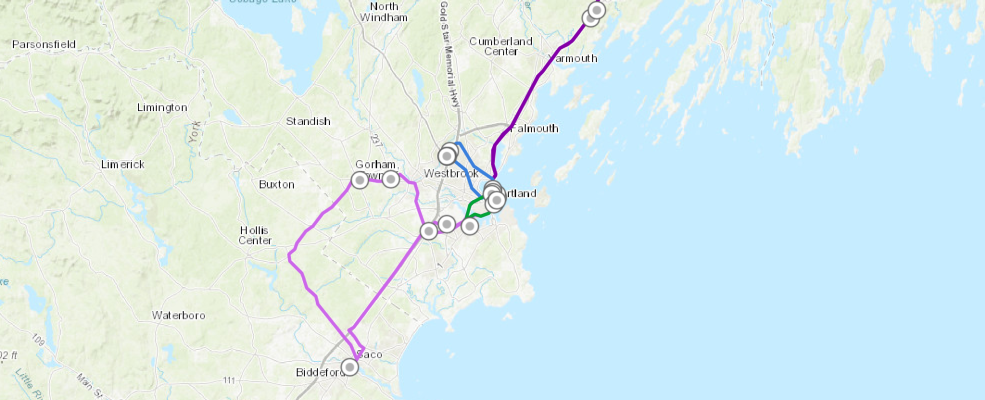

In [12]:
webmap.add_layer(project.assignments_layer)
webmap